# Case study: Fort Lauderdale Flooding

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import xarray as xr
import numpy as np

In [2]:
from pansat.catalog import Index
from pansat.granule import merge_granules
from pansat.products.satellite.gpm import l1c_gcomw1_amsr2
from pansat.geometry import LonLatRect
files = sorted(list(Path("/pdata4/archive/GPM/1C_AMSR2_V7/2304/230413//").glob("**/*.HDF5")))
index = Index.index(l1c_gcomw1_amsr2, files)
roi = LonLatRect(-78, 24, -82, 28)
granules = merge_granules(index.find(roi=roi))
granules

[Granule(filename='1C.GCOMW1.AMSR2.XCAL2016-V.20230413-S182046-E195938.058006.V07A.HDF5', start_time='2023-04-13 18:45:29.078000', end_time='2023-04-13 18:57:51.507000', primary_index_name='scans', primary_index_range='(988, 1484)', secondary_index_name='pixels', secondary_index_range='(0, 243)')]

In [4]:
from gprof_nn.data.l1c import L1CFile
l1c_file = L1CFile(files[0])

In [11]:
l1c_file.extract_scan_range(102, 500, "/home/simon/src/noaagprof/1C.GCOMW1.AMSR2.XCAL2016-V.20230413-S001303-E015155.057995.V07A.HDF5")
                            

## Run GPROF-NN 1D

In [3]:
from gprof_nn.retrieval import L1CLoader
loader = L1CLoader(granules, "1d")

In [4]:
from pytorch_retrieve.architectures import load_model
from pytorch_retrieve.inference import run_inference, InferenceConfig
import torch
result_file = Path("gprof_nn_1d_na_ft_202304123.nc")
if not result_file.exists():
    model = load_model("/gdata1/simon/gprof_v8/models/amsr2/1d_na_ft/checkpoints/gprof_nn_1d-v1.ckpt").eval()
    results = run_inference(model, loader, InferenceConfig(batch_size=2048), device=torch.device("cuda:2"))
    results[0].to_netcdf(result_file)
results_1d_na_ft = xr.load_dataset(result_file)

In [5]:
result_file = Path("gprof_nn_1d_na_202304123.nc")
if not result_file.exists():
    model = load_model("/gdata1/simon/gprof_v8/models/amsr2/1d_na/checkpoints/gprof_nn_1d-v3.ckpt").eval()
    results = run_inference(model, loader, InferenceConfig(batch_size=2048), device=torch.device("cuda:2"))
    results[0].to_netcdf(result_file)
results_1d_na = xr.load_dataset(result_file)

## Run GPROF-NN 3D

In [6]:
from gprof_nn.retrieval import L1CLoader
loader = L1CLoader(granules, "3d")

In [88]:
%rm gprof_nn_3d_na_ft_202304123.nc

In [89]:
from pytorch_retrieve.inference import InferenceConfig

cfg = InferenceConfig(batch_size=8, tile_size=(128, 64), spatial_overlap=16)
result_file = Path("gprof_nn_3d_na_ft_202304123.nc")
if not result_file.exists():
    model = load_model("/gdata1/simon/gprof_v8/models/amsr2/3d_na_ft/gprof_nn_3d_ft.pt")
    results = run_inference(model, loader, cfg, device=torch.device("cuda:2"))
    results[0].to_netcdf(result_file)
results_3d_na_ft = xr.load_dataset(result_file)

Output()

[10:43:08] INFO     Invoking the preprocesor 'gprof2023pp_AMSR2_L1C' using the following        ]8;id=498942;file:///home/simon/src/gprof_nn/gprof_nn/data/preprocessor.py\preprocessor.py]8;;\:]8;id=923413;file:///home/simon/src/gprof_nn/gprof_nn/data/preprocessor.py#793\793]8;;\
                    command: gprof2023pp_AMSR2_L1C 1487058_pp CLIMATOLOGY                                          
                    /tmp/tmpre6kxdrs/1C.GCOMW1.AMSR2.XCAL2016-V.20230413-S182046-E195938.058006                    
                    .V07A.HDF5 /qdata2/archive/ERA5/ /qdata1/pbrown/gpm/ppancillary/                               
                    /qdata1/pbrown/gpm/ppingest/ /tmp/tmp8a0h_wo5                                                  

In [90]:
%rm gprof_nn_3d_na_202304123.nc

In [91]:
result_file = Path("gprof_nn_3d_na_202304123.nc")
if not result_file.exists():
    model = load_model("/gdata1/simon/gprof_v8/models/amsr2/3d_na/gprof_nn_3d.pt")
    results = run_inference(model, loader, cfg, device=torch.device("cuda:2"))
    results[0].to_netcdf(result_file)
results_3d_na = xr.load_dataset(result_file)

Output()

[10:43:27] INFO     Invoking the preprocesor 'gprof2023pp_AMSR2_L1C' using the following        ]8;id=563641;file:///home/simon/src/gprof_nn/gprof_nn/data/preprocessor.py\preprocessor.py]8;;\:]8;id=511595;file:///home/simon/src/gprof_nn/gprof_nn/data/preprocessor.py#793\793]8;;\
                    command: gprof2023pp_AMSR2_L1C 1487058_pp CLIMATOLOGY                                          
                    /tmp/tmp51l2glw9/1C.GCOMW1.AMSR2.XCAL2016-V.20230413-S182046-E195938.058006                    
                    .V07A.HDF5 /qdata2/archive/ERA5/ /qdata1/pbrown/gpm/ppancillary/                               
                    /qdata1/pbrown/gpm/ppingest/ /tmp/tmpxpw3phmq                                                  

In [23]:
from pansat.products.satellite.gpm import l2a_gprof_gcomw1_amsr2

recs = l2a_gprof_gcomw1_amsr2.get(granules[0].file_record.temporal_coverage)
results_gprof = l2a_gprof_gcomw1_amsr2.open(recs[0].local_path)
results_gprof = results_gprof[{"scans": slice(*granules[0].primary_index_range)}]

[08:41:44] WARNING  Found table named 'satellite.goes.l1b_goes18_rad_c02_full_disk' in database but    ]8;id=177831;file:///home/simon/src/pansat/pansat/catalog/index.py\index.py]8;;\:]8;id=591740;file:///home/simon/src/pansat/pansat/catalog/index.py#267\267]8;;\
                    could not load find a corresponding pansat product.                                            

Please enter your pansat user password:


 ········


[08:41:54] ERROR    Indexing of file record                                                            ]8;id=27937;file:///home/simon/src/pansat/pansat/catalog/index.py\index.py]8;;\:]8;id=937394;file:///home/simon/src/pansat/pansat/catalog/index.py#300\300]8;;\
                    'FileRecord(filename='2A.GCOMW1.AMSR2.GPROF2021v1.20230413-S182046-E195938.058006.             
                    V07A.HDF5',                                                                                    
                    local_path=PosixPath('/gdata1/simon/satellite_data/gpm/2a/gcomw1/amsr2/2A.GCOMW1.A             
                    MSR2.GPROF2021v1.20230413-S182046-E195938.058006.V07A.HDF5'),                                  
                    product=<pansat.products.satellite.gpm.GPROFProduct object at 0x7f42dc602560>,                 
                    provider=<pansat.download.providers.ges_disc.GesDiscProviderDay object at                      
                    0x7f420594fdc0>,                                                                               
                    remote_path='https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L2/GPM_2AGPROFGCOMW1AMS             
                    R2.07/2023/103/2A.GCOMW1.AMSR2.GPROF2021v1.20230413-S182046-E195938.058006.V07A.HD             
                    F5')' failed with the following error:                                                         
                     This product description does not contain any granule information and can                     
                    therefore not provide any granules.                                                            
                    Traceback (most recent call last):                                                             
                      File "/home/simon/src/pansat/pansat/catalog/index.py", line 298, in index                    
                        granules += _get_index_data(product, rec)                                                  
                      File "/home/simon/src/pansat/pansat/catalog/index.py", line 78, in                           
                    _get_index_data                                                                                
                        return product.get_granules(rec)                                                           
                      File "/home/simon/src/pansat/pansat/products/satellite/gpm/__init__.py", line                
                    218, in get_granules                                                                           
                        for granule_data in self.description.get_granule_data(                                     
                      File "/home/simon/src/pansat/pansat/products/product_description.py", line 577,              
                    in get_granule_data                                                                            
                        raise ValueError(                                                                          
                    ValueError: This product description does not contain any granule information and              
                    can therefore not provide any granules.                                                        

True
satellite.gpm.l2a_gprof2021v1_gcomw1_amsr2_v07a
satellite.gpm.l2a_gprof2021v1_gcomw1_amsr2_v07a


           ERROR    Indexing of file record                                                            ]8;id=669313;file:///home/simon/src/pansat/pansat/catalog/index.py\index.py]8;;\:]8;id=310216;file:///home/simon/src/pansat/pansat/catalog/index.py#300\300]8;;\
                    'FileRecord(filename='2A.GCOMW1.AMSR2.GPROF2021v1.20230413-S182046-E195938.058006.             
                    V07A.HDF5',                                                                                    
                    local_path=PosixPath('/gdata1/simon/satellite_data/gpm/2a/gcomw1/amsr2/2A.GCOMW1.A             
                    MSR2.GPROF2021v1.20230413-S182046-E195938.058006.V07A.HDF5'),                                  
                    product=<pansat.products.satellite.gpm.GPROFProduct object at 0x7f42dc602560>,                 
                    provider=<pansat.download.providers.ges_disc.GesDiscProviderDay object at                      
                    0x7f420594fdc0>,                                                                               
                    remote_path='https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L2/GPM_2AGPROFGCOMW1AMS             
                    R2.07/2023/103/2A.GCOMW1.AMSR2.GPROF2021v1.20230413-S182046-E195938.058006.V07A.HD             
                    F5')' failed with the following error:                                                         
                     This product description does not contain any granule information and can                     
                    therefore not provide any granules.                                                            
                    Traceback (most recent call last):                                                             
                      File "/home/simon/src/pansat/pansat/catalog/index.py", line 298, in index                    
                        granules += _get_index_data(product, rec)                                                  
                      File "/home/simon/src/pansat/pansat/catalog/index.py", line 78, in                           
                    _get_index_data                                                                                
                        return product.get_granules(rec)                                                           
                      File "/home/simon/src/pansat/pansat/products/satellite/gpm/__init__.py", line                
                    218, in get_granules                                                                           
                        for granule_data in self.description.get_granule_data(                                     
                      File "/home/simon/src/pansat/pansat/products/product_description.py", line 577,              
                    in get_granule_data                                                                            
                        raise ValueError(                                                                          
                    ValueError: This product description does not contain any granule information and              
                    can therefore not provide any granules.                                                        

True
satellite.gpm.l2a_gprof2021v1_gcomw1_amsr2_v07a
satellite.gpm.l2a_gprof2021v1_gcomw1_amsr2_v07a


In [33]:
from pansat.products.ground_based.mrms import precip_rate
recs = precip_rate.find_files(granules[0].time_range)
rec = recs[len(recs) // 2].get()
results_mrms = precip_rate.open(rec)
lon_min, lon_max = -92, -75
lat_min, lat_max = 22, 40
lons = results_mrms.longitude.data
lats = results_mrms.latitude.data
lon_mask = (lon_min < lons) * (lons < lon_max)
lat_mask = (lat_min < lats) * (lats < lat_max)
results_mrms = results_mrms[{"longitude": lon_mask, "latitude": lat_mask}]

In [25]:
from gprof_nn.plotting import set_style
set_style(latex=False)

In [26]:
granules[0].time_range

TimeRange(start='2023-04-13T18:45:29.078000', end='2023-04-13T18:57:51.507000')

In [39]:
sim_data = xr.load_dataset("/gdata1/simon/gprof_v8/training_data/amsr2/1d/sim_20181006004340_20181006021614.nc")

In [42]:
tbs = sim_data.brightness_temperatures.data
tbs_sim = sim_data.simulated_brightness_temperatures.data
tb_biases = sim_data.brightness_temperature_biases

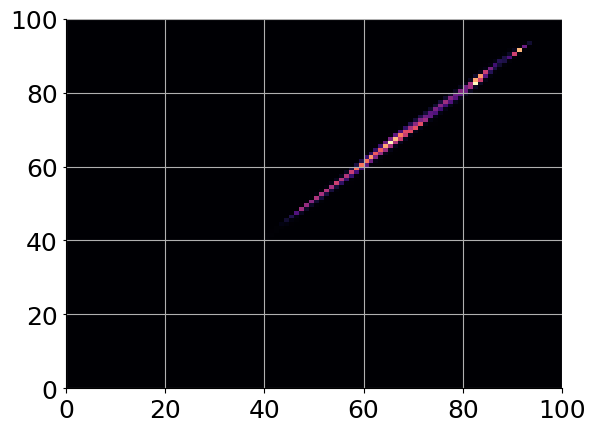

In [78]:
chan = 9 
bins = np.linspace(100, 300, 101)
img = np.histogram2d(tbs[..., chan], tbs_sim[..., chan] - tb_biases[..., chan], bins=bins)[0]
plt.pcolormesh(img.T)

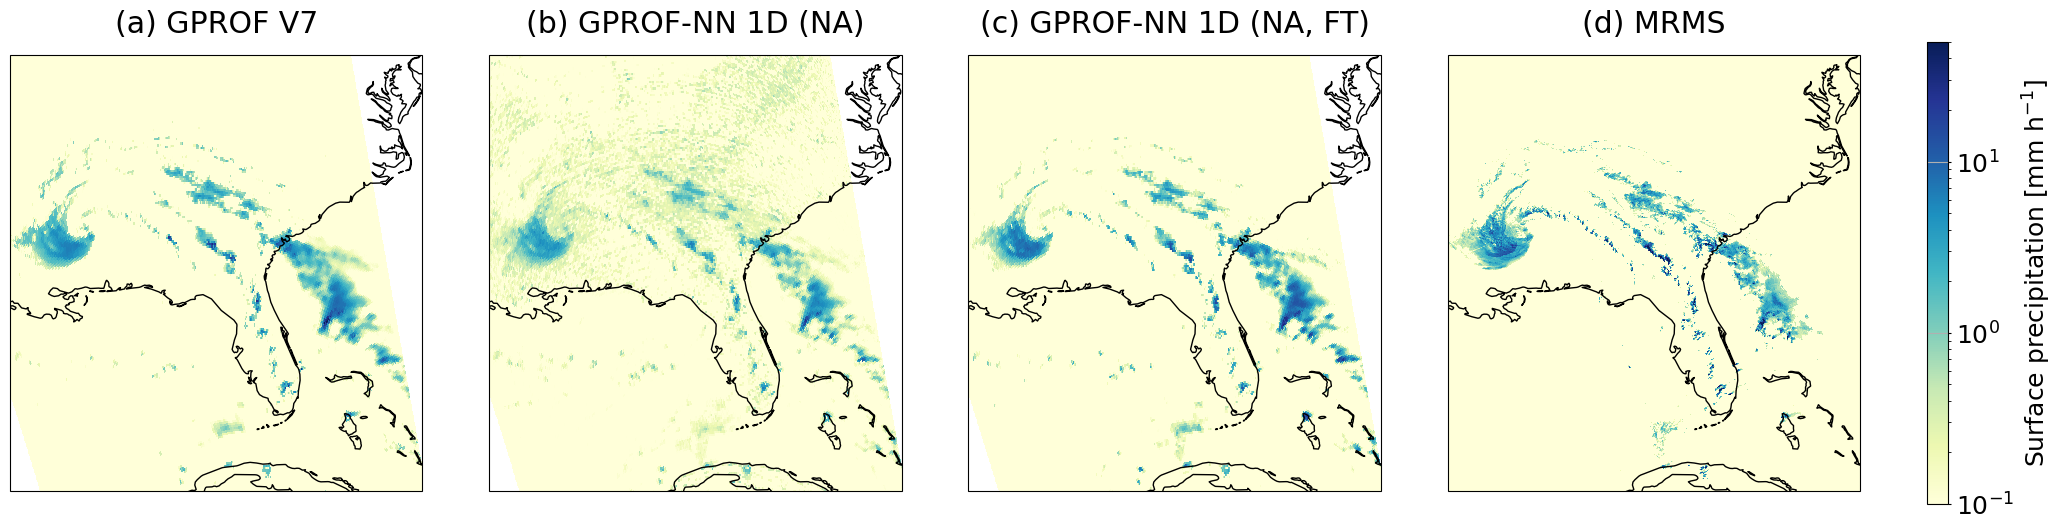

In [95]:
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
ind = 0

crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(25, 6))
gs = GridSpec(1, 5, width_ratios=[1.0, 1.0, 1.0, 1.0, 0.05])

lon_min, lon_max = -92, -75
lat_min, lat_max = 22, 40
cmap = "YlGnBu"

norm = LogNorm(1e-1, 5e1)
ax = fig.add_subplot(gs[0, 0], projection=crs)
lons = results_gprof.longitude.data
lats = results_gprof.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_gprof.surface_precipitation, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(a) GPROF V7")

norm = LogNorm(1e-1, 5e1)
ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = results_1d_na.longitude.data
lats = results_1d_na.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_1d_na.surface_precip_combined, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(b) GPROF-NN 1D (NA)")

norm = LogNorm(1e-1, 5e1)
ax = fig.add_subplot(gs[0, 2], projection=crs)
lons = results_1d_na.longitude.data
lats = results_1d_na.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_1d_na_ft.surface_precip_combined, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(c) GPROF-NN 1D (NA, FT)")

ax = fig.add_subplot(gs[0, 3], projection=crs)
lons = results_mrms.longitude.data
lats = results_mrms.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_mrms.precip_rate, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(d) MRMS")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(m, label="Surface precipitation [mm h$^{-1}$]", cax=cax)

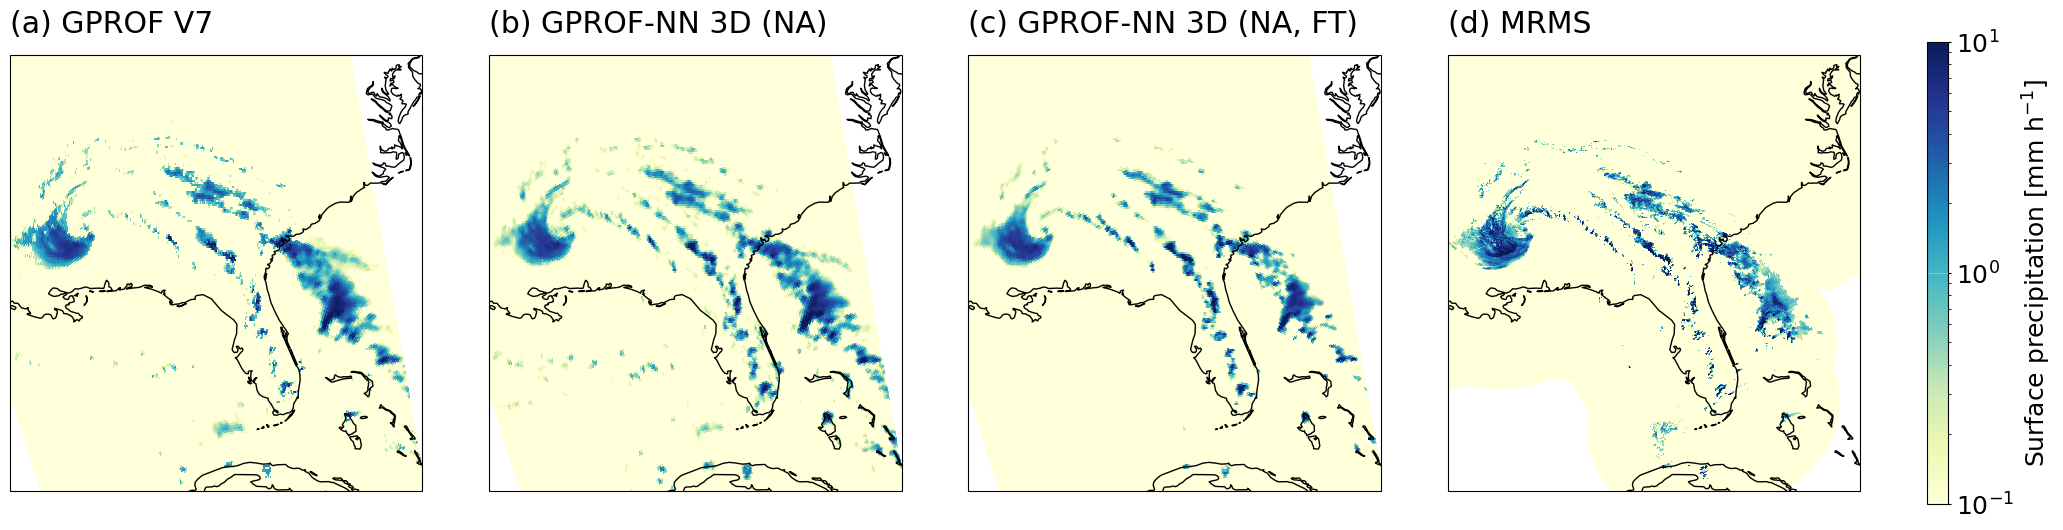

In [99]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
ind = 0

crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(25, 6))
gs = GridSpec(1, 5, width_ratios=[1.0, 1.0, 1.0, 1.0, 0.05])

norm = LogNorm(1e-1, 1e1)
lon_min, lon_max = -92, -75
lat_min, lat_max = 22, 40
cmap = "YlGnBu"

ax = fig.add_subplot(gs[0, 0], projection=crs)
lons = results_gprof.longitude.data
lats = results_gprof.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_gprof.surface_precipitation, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(a) GPROF V7", loc="left")

ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = results_3d_na.longitude.data
lats = results_3d_na.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_3d_na.surface_precip_combined, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(b) GPROF-NN 3D (NA)", loc="left")

ax = fig.add_subplot(gs[0, 2], projection=crs)
lons = results_3d_na.longitude.data
lats = results_3d_na.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_3d_na_ft.surface_precip_combined, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(c) GPROF-NN 3D (NA, FT)", loc="left")

ax = fig.add_subplot(gs[0, 3], projection=crs)
lons = results_mrms.longitude.data
lats = results_mrms.latitude.data
sp_mrms = results_mrms.precip_rate.data.copy()
mask = sp_mrms < 0.0
sp_mrms[mask] = np.nan
m = ax.pcolormesh(lons, lats, np.maximum(sp_mrms, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(d) MRMS", loc="left")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(m, label="Surface precipitation [mm h$^{-1}$]", cax=cax)

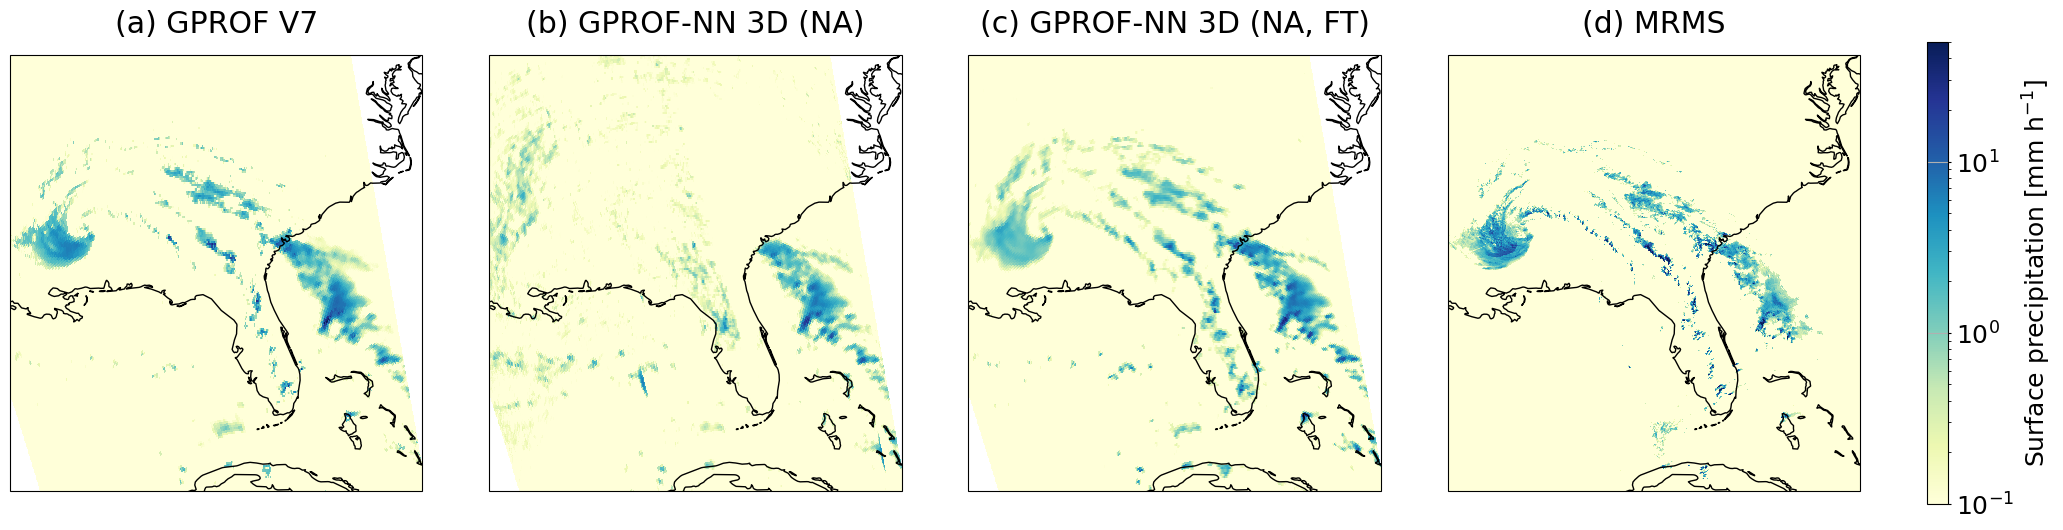

In [87]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
ind = 0

crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(25, 6))
gs = GridSpec(1, 5, width_ratios=[1.0, 1.0, 1.0, 1.0, 0.05])

lon_min, lon_max = -92, -75
lat_min, lat_max = 22, 40
cmap = "YlGnBu"

norm = LogNorm(1e-1, 5e1)
ax = fig.add_subplot(gs[0, 0], projection=crs)
lons = results_gprof.longitude.data
lats = results_gprof.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_gprof.surface_precipitation, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(a) GPROF V7")

norm = LogNorm(1e-1, 5e1)
ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = results_3d_na.longitude.data
lats = results_3d_na.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_3d_na.surface_precip_combined, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(b) GPROF-NN 3D (NA)")

norm = LogNorm(1e-1, 5e1)
ax = fig.add_subplot(gs[0, 2], projection=crs)
lons = results_3d_na.longitude.data
lats = results_3d_na.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_3d_na_ft.surface_precip_combined, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(c) GPROF-NN 3D (NA, FT)")

ax = fig.add_subplot(gs[0, 3], projection=crs)
lons = results_mrms.longitude.data
lats = results_mrms.latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results_mrms.precip_rate, 1e-3), norm=norm, cmap=cmap)
ax.coastlines()
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
ax.set_title("(d) MRMS")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(m, label="Surface precipitation [mm h$^{-1}$]", cax=cax)

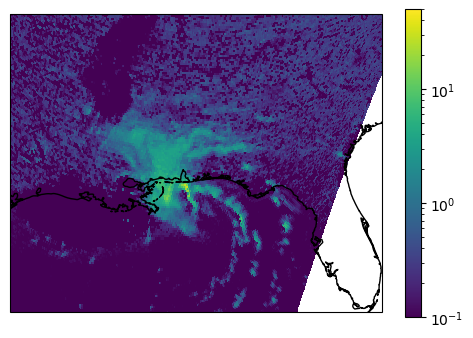

In [107]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
ind = 5

crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, projection=crs)

lons = results[ind].longitude.data
lats = results[ind].latitude.data
m = ax.pcolormesh(lons, lats, np.maximum(results[ind].surface_precip_combined, 1e-3), norm=norm)
ax.coastlines()
plt.xlim([-95, -80])
plt.ylim([25, 37])
plt.colorbar(m)

In [118]:
finetuning_files = sorted(list(Path("/gdata1/simon/gprof_v8/finetuning_data/").glob("**/*.nc")))

In [168]:
for path in finetuning_files:
    print(path)
    dataset = xr.load_dataset(path)
    dataset.attrs["source"] = "collocs"
    sp = dataset.surface_precip_combined.data
    sp[sp < 0] = np.nan
    dataset.to_netcdf(path)
    

/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20150930232509_20150930233026.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002000911_20151002001450.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002005831_20151002010401.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002014748_20151002015318.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002023706_20151002024229.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002032624_20151002033148.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002222556_20151002222850.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002222556_20151002222907.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151002231450_20151002231824.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151003000406_20151003001003.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_20151003005321_20151003005921.nc
/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/cmb_2015100301423

AttributeError: 'Dataset' object has no attribute 'surface_precip_combined'

In [163]:
from gprof_nn.data.training_data import GPROFNN1DDataset
val_data = GPROFNN1DDataset("/gdata1/simon/gprof_v8/finetuning_data/amsr2/1d/", targets=["surface_precip_combined"])

In [164]:
xs = []
ys = []
ind = 0
for x, y in val_data:
    xs.append(x["brightness_temperatures"])
    ys.append(y["surface_precip_combined"])
    ind += 1
tbs = torch.stack(xs, 0)
precip = torch.stack(ys, 0)

In [136]:
(precip < 1e-3).to(torch.float32).mean()

tensor(0.9412)

In [165]:
precip.max()

tensor(251.4808)

In [166]:
precip.min()

tensor(-9999.9004)

In [146]:
bins = np.logspace(-2, 3, 101)
y = np.histogram(precip, bins=bins)[0]

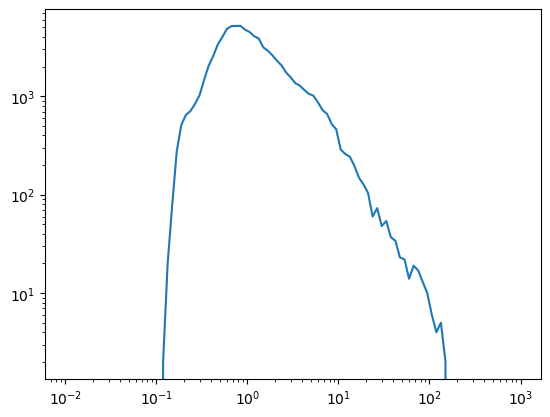

In [147]:
x = 0.5 * (bins[1:] + bins[:-1])
plt.plot(x, y)
plt.yscale("log")
plt.xscale("log")

In [160]:
tbs[..., 9]

tensor([194.9400, 267.9600, 208.3000,  ..., 272.2500, 271.8000, 268.5300])